# Patch Duration vs. Morphological Calls(63x) per Post Patch Outcomes

##### Date:Update to recent csv by custom reports cell report card 'T301x', 'mIVSCC-MET'

In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

import pg8000          #pg8000 access SQL databases
import pandas as pd    #pandas will be needed to work in a dataframe

from IPython.display import display #Found this to display all columns in a table

#Makes a white backround with gray horizontal gridmarks at y-values
sns.set_style('whitegrid')
sns.set_context('notebook')

#Context: paper
#Context: notebook
#Context: talk
#Context: poster

In [2]:
#Code from Agata
#Opens LIMS, makes a query and then closes LIMS after

def _connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    conn = pg8000.connect(user=user, host=host, database=database, password=password, port=port)
    return conn, conn.cursor()

def _select(cursor, query):
    cursor.execute(query)
    columns = [ d[0] for d in cursor.description ]
    return [ dict(zip(columns, c)) for c in cursor.fetchall() ]

def limsquery(query, user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    """A function that takes a string containing a SQL query, connects to the LIMS database and outputs the result."""
    conn, cursor = _connect(user, host, database, password, port)
    try:
        results = _select(cursor, query)
    finally:
        #THESE ARE IMPORTANT!!!!!! (Every query needs to be closed when done)
        #This closes query
        cursor.close()             
        conn.close()
    return results


#This last function will take our query results and put them in a dataframe so that they are easy to work with
def get_lims_dataframe(query):
    '''Return a dataframe with lims query'''
    result = limsquery(query)
    try:
        data_df = pd.DataFrame(data=result, columns=result[0].keys())
    except IndexError:
        print "Could not find results for your query."
        data_df = pd.DataFrame()
    return data_df

##### postpatch_func.py by Rusty from Stash 

In [3]:
#Methods nucleated(x) to entire cell(v)
#Searches for different names under same variable (Ex. Nucleated = nuc, nuc_vis...)

def nucleated(x):
    nucleus = x[(x['anno.postPatch_label'] == 'Nucleated') | 
                      (((x['anno.postPatch_label'] == 'nucleus_visible') | 
                      (x['anno.postPatch_label'] == 'nucleus_present')) & 
                      (x['anno.endPipetteR_label'] >= 500))]
    return nucleus #nuc_high_seal

def partial_nucleated(y):
    partial = y[(y['anno.postPatch_label'] == 'Partial-Nucleus') | 
                     (((y['anno.postPatch_label'] == 'nucleus_present') | 
                     (y['anno.postPatch_label'] == 'nucleus_visible')) & 
                     (y["anno.endPipetteR_label"] <= 499))]
    return partial #nuc_low_seal

def outside_out(z):
    outside = z[(z['anno.postPatch_label'] == 'Outside-Out') | 
                         (((z['anno.postPatch_label'] == 'nucleus_absent') | 
                         (z['anno.postPatch_label'] == 'no_nucleus_visible')) & 
                         (z['anno.endPipetteR_label'] >= 500))]
    return outside #no_nuc_high_seal

def no_seal(w): 
    no = w[(w['anno.postPatch_label'] == 'No-Seal') | 
                        (((w['anno.postPatch_label'] == 'nucleus_absent') | 
                        (w['anno.postPatch_label'] == 'no_nucleus_visible')) & 
                        (w['anno.endPipetteR_label'] <= 499))]
    return no #no_nuc_low_seal
    
def entire_cell(v):
    entire = v[(v['anno.postPatch_label'] == 'Entire-Cell') | 
               (v['anno.postPatch_label'] == 'entire_cell')]
    return entire
#----------------------#

#variable['post patch class'] = 'Term'
#Term is an output displayed in the post patch class column

def reclassify(df):
    oo = outside_out(df)
    oo['post patch class'] = 'No nuc-high seal'
    
    nu = nucleated(df)
    nu['post patch class'] = 'Nuc-high seal'   
    
    ns = no_seal(df)
    ns['post patch class'] = 'No nuc-low seal'
    
    pn = partial_nucleated(df)
    pn['post patch class'] = 'Nuc-low seal'
    
    ec = entire_cell(df)
    ec['post patch class'] = 'Entire cell'
    return  nu, pn, oo, ns, ec

#nuc, partnuc, out, noseal, ent = reclassify(ps)
#----------------------#

def concat_df(a, b, c, d, e):
    frames = (a, b, c, d, e)
    df = pd.concat(frames)
    return df
#(oo, nu, ns, pn, ec)

def postpatch_reclass(df):
    return concat_df(*reclassify(df))



##### Creating lims_df from accessing LIMS

In [4]:
my_query = 'SELECT specimens.name, specimens.patched_cell_container FROM specimens'

lims_df = get_lims_dataframe(my_query)
lims_df.tail()

,patched_cell_container,name
441841,P8S4_171016_356_A01,Chrna2-Cre_OE25;Ai14-355016.05.02.02
441842,PBS4_180306_502_A01,Pvalb-IRES-Cre;Ai14-378390.04.02.01
441843,None,Nr5a1-Cre;Ai14-378059.10.06.01
441844,None,Nr5a1-Cre;Ai14-378059.11.06.01
441845,None,Nos1-CreERT2;Sst-IRES-FlpO;Ai65-377372.06.02


##### Reads 63x.csv & shiny.csv

In [5]:
morph_df = pd.read_csv("63x.csv")
shiny_df = pd.read_csv("shiny.csv")

##### Creating shiny_df from shiny.csv

In [6]:
shiny_initial = ['anno.sample_id',
                 'anno.Total_time_label',
                 'anno.Ephys_time_label',
                 'anno.Retraction_time_label',
                 'anno.postPatch_label',
                 'anno.endPipetteR_label']
shiny_df = shiny_df[shiny_initial]
shiny_df.head()

,anno.sample_id,anno.Total_time_label,anno.Ephys_time_label,anno.Retraction_time_label,anno.postPatch_label,anno.endPipetteR_label
0,P1S4_160318_069_A01,0,0,0,O/O,0.0
1,P1S4_160407_108_A01,0,0,0,nucleated patch,0.0
2,P1S4_160407_109_A01,0,0,0,partial nucleus,0.0
3,P1S4_160407_112_A01,0,0,0,o/o,0.0
4,P1S4_160407_113_A01,0,0,0,0,0.0


##### Merging shiny_df with lims_df to create shiny_lims_df

In [7]:
#Left = shiny 
#Right = LIMS
#Left merge = contains all of shiny but LIMS only displays the matched info with shiny

shiny_lims_df = pd.merge(left = shiny_df, 
                         right = lims_df, 
                         left_on = 'anno.sample_id', 
                         right_on = 'patched_cell_container', 
                         how = 'left')

In [8]:
shiny_lims_df.head()

,anno.sample_id,anno.Total_time_label,anno.Ephys_time_label,anno.Retraction_time_label,anno.postPatch_label,anno.endPipetteR_label,patched_cell_container,name
0,P1S4_160318_069_A01,0,0,0,O/O,0.0,P1S4_160318_069_A01,Ndnf-IRES2-dgCre;Ai14-234626.02.L.01
1,P1S4_160407_108_A01,0,0,0,nucleated patch,0.0,P1S4_160407_108_A01,Ndnf-IRES2-dgCre;Ai14-237573.07.R.01
2,P1S4_160407_109_A01,0,0,0,partial nucleus,0.0,P1S4_160407_109_A01,Ndnf-IRES2-dgCre;Ai14-237573.07.L.01
3,P1S4_160407_112_A01,0,0,0,o/o,0.0,P1S4_160407_112_A01,Ndnf-IRES2-dgCre;Ai14-237573.07.L.02
4,P1S4_160407_113_A01,0,0,0,0,0.0,P1S4_160407_113_A01,Ndnf-IRES2-dgCre;Ai14-237573.07.L.03


##### Creating morph_df from 63x.csv

In [9]:
morph_initial = ['recording_date',
                 'project', 
                 'cell_specimen_name', 
                 'ims63x_go_no_go']
morph_df = morph_df[morph_initial]
morph_df.tail()

,recording_date,project,cell_specimen_name,ims63x_go_no_go
6028,NaN,mIVSCC-MET,Vip-IRES-Cre;Ai14-363633.04.01.01,NaN
6029,NaN,mIVSCC-MET,Vip-IRES-Cre;Ai14-363633.04.01.02,63x go
6030,NaN,mIVSCC-MET,Vipr2-IRES2-Cre;Pvalb-T2A-FlpO;Ai65-349552.03....,NaN
6031,NaN,mIVSCC-MET,Vipr2-IRES2-Cre;Pvalb-T2A-FlpO;Ai65-349552.05....,NaN
6032,NaN,mIVSCC-MET,Vipr2-IRES2-Cre;Pvalb-T2A-FlpO;Ai65-349552.06....,NaN


##### Merging morph_df with shiny_lims_df to create final_df

In [10]:
#Inner merge = contains only matching data of both morph_df and shiny_LIMS_df

final_df = pd.merge(left = morph_df, 
                    right = shiny_lims_df, 
                    left_on = 'cell_specimen_name', 
                    right_on = 'name', 
                    how = 'inner')

In [11]:
final_df.tail(50)

,recording_date,project,cell_specimen_name,ims63x_go_no_go,anno.sample_id,anno.Total_time_label,anno.Ephys_time_label,anno.Retraction_time_label,anno.postPatch_label,anno.endPipetteR_label,patched_cell_container,name
2599,NaN,mIVSCC-MET,Rbp4-Cre_KL100;Ai14-357010.04.02.03,63x go,P6S4_171030_252_A01,265,79,54,nucleus_present,150.0,P6S4_171030_252_A01,Rbp4-Cre_KL100;Ai14-357010.04.02.03
2600,NaN,mIVSCC-MET,Rbp4-Cre_KL100;Ai14-362155.03.01.01,NaN,P9S4_171201_401_A01,373,1,79,nucleus_absent,7.6,P9S4_171201_401_A01,Rbp4-Cre_KL100;Ai14-362155.03.01.01
2601,NaN,mIVSCC-MET,Rbp4-Cre_KL100;Ai14-362155.03.02.01,NaN,PBS4_171201_501_A01,16,0,0,nucleus_absent,0.0,PBS4_171201_501_A01,Rbp4-Cre_KL100;Ai14-362155.03.02.01
2602,NaN,mIVSCC-MET,Rbp4-Cre_KL100;Ai14-362155.05.02.01,NaN,PAS4_171201_451_A01,329,301,28,nucleus_absent,16.0,PAS4_171201_451_A01,Rbp4-Cre_KL100;Ai14-362155.05.02.01
2603,NaN,mIVSCC-MET,Rbp4-Cre_KL100;Ai14-366313.03.01.01,63x go,P6S4_171211_251_A01,342,53,112,nucleus_present,1100.0,P6S4_171211_251_A01,Rbp4-Cre_KL100;Ai14-366313.03.01.01
2604,NaN,T301x,Rorb-IRES2-Cre;Ai14-318659.04.01.02,NaN,P1S4_170510_004_A01,0,0,0,No-Seal,0.0,P1S4_170510_004_A01,Rorb-IRES2-Cre;Ai14-318659.04.01.02
2605,NaN,T301x,Rorb-IRES2-Cre;Ai14-318659.04.02.02,NaN,P1S4_170510_006_A01,0,0,0,Nucleated,0.0,P1S4_170510_006_A01,Rorb-IRES2-Cre;Ai14-318659.04.02.02
2606,NaN,mIVSCC-MET,Rorb-IRES2-Cre;Ai14-355888.04.01.01,NaN,P9S4_171027_401_A01,296,2,1,nucleus_absent,11.0,P9S4_171027_401_A01,Rorb-IRES2-Cre;Ai14-355888.04.01.01
2607,NaN,mIVSCC-MET,Rorb-IRES2-Cre;Ai14-355888.04.02.01,NaN,P8S4_171027_351_A01,93,2,1,nucleus_absent,0.0,P8S4_171027_351_A01,Rorb-IRES2-Cre;Ai14-355888.04.02.01
2608,NaN,mIVSCC-MET,Rorb-IRES2-Cre;Ai14-355888.06.02.01,NaN,PAS4_171027_451_A01,280,299,21,nucleus_absent,10.3,PAS4_171027_451_A01,Rorb-IRES2-Cre;Ai14-355888.06.02.01


##### Creating Date column using patched_cell_container column

In [12]:
final_df['Date'] = final_df['patched_cell_container'].str[5:11]

In [13]:
final_df.tail()

,recording_date,project,cell_specimen_name,ims63x_go_no_go,anno.sample_id,anno.Total_time_label,anno.Ephys_time_label,anno.Retraction_time_label,anno.postPatch_label,anno.endPipetteR_label,patched_cell_container,name,Date
2644,NaN,mIVSCC-MET,Vip-IRES-Cre;Ai14-363633.04.01.01,NaN,P6S4_171219_251_A01,447,98,151,nucleus_present,1500.0,P6S4_171219_251_A01,Vip-IRES-Cre;Ai14-363633.04.01.01,171219
2645,NaN,mIVSCC-MET,Vip-IRES-Cre;Ai14-363633.04.01.02,63x go,P6S4_171219_252_A01,397,89,126,nucleus_present,2500.0,P6S4_171219_252_A01,Vip-IRES-Cre;Ai14-363633.04.01.02,171219
2646,NaN,mIVSCC-MET,Vipr2-IRES2-Cre;Pvalb-T2A-FlpO;Ai65-349552.03....,NaN,PBS4_171013_501_A01,319,2,0,nucleus_absent,0.0,PBS4_171013_501_A01,Vipr2-IRES2-Cre;Pvalb-T2A-FlpO;Ai65-349552.03....,171013
2647,NaN,mIVSCC-MET,Vipr2-IRES2-Cre;Pvalb-T2A-FlpO;Ai65-349552.05....,NaN,P8S4_171013_351_A01,-39114,300,-39418,nucleus_absent,8.0,P8S4_171013_351_A01,Vipr2-IRES2-Cre;Pvalb-T2A-FlpO;Ai65-349552.05....,171013
2648,NaN,mIVSCC-MET,Vipr2-IRES2-Cre;Pvalb-T2A-FlpO;Ai65-349552.06....,NaN,PAS4_171013_451_A01,443,300,29,nucleus_absent,15.0,PAS4_171013_451_A01,Vipr2-IRES2-Cre;Pvalb-T2A-FlpO;Ai65-349552.06....,171013


##### Indexing Date column then sorting by date index

In [14]:
final_df = final_df.set_index('Date')
final_df = final_df.sort_index()

In [15]:
final_df.head()

,recording_date,project,cell_specimen_name,ims63x_go_no_go,anno.sample_id,anno.Total_time_label,anno.Ephys_time_label,anno.Retraction_time_label,anno.postPatch_label,anno.endPipetteR_label,patched_cell_container,name
Date,,,,,,,,,,,,
160510,5/10/2016 10:48,T301x,Rorb-IRES2-Cre-D;Ai14-245133.07.01.01,NaN,P1S4_160510_455_A01,0,0,0,0,0.0,P1S4_160510_455_A01,Rorb-IRES2-Cre-D;Ai14-245133.07.01.01
160511,5/11/2016 11:38,T301x,Scnn1a-Tg2-Cre;Ai14-245345.02.02.01,NaN,P1S4_160511_471_A01,0,0,0,0,0.0,P1S4_160511_471_A01,Scnn1a-Tg2-Cre;Ai14-245345.02.02.01
160511,5/11/2016 13:07,T301x,Scnn1a-Tg2-Cre;Ai14-245345.07.01.01,NaN,P1S4_160511_472_A01,0,0,0,Partial nucleus,0.0,P1S4_160511_472_A01,Scnn1a-Tg2-Cre;Ai14-245345.07.01.01
160511,5/11/2016 13:48,T301x,Scnn1a-Tg2-Cre;Ai14-245345.07.01.02,NaN,P1S4_160511_473_A01,0,0,0,0,0.0,P1S4_160511_473_A01,Scnn1a-Tg2-Cre;Ai14-245345.07.01.02
160512,5/12/2016 14:24,T301x,Rorb-IRES2-Cre-D;Ai14-245132.07.02.04,NaN,P1S4_160512_485_A01,0,0,0,o/o,0.0,P1S4_160512_485_A01,Rorb-IRES2-Cre-D;Ai14-245132.07.02.04


In [16]:
final_df.tail()

,recording_date,project,cell_specimen_name,ims63x_go_no_go,anno.sample_id,anno.Total_time_label,anno.Ephys_time_label,anno.Retraction_time_label,anno.postPatch_label,anno.endPipetteR_label,patched_cell_container,name
Date,,,,,,,,,,,,
180213,2/13/2018 19:05,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.03.02.03,NaN,PBS4_180213_503_A01,672,45,0,nucleus_absent,0.0,PBS4_180213_503_A01,Pvalb-IRES-Cre;Ai14-375845.03.02.03
180213,2/13/2018 18:09,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.03.01.01,NaN,P9S4_180213_401_A01,838,43,231,nucleus_absent,900.0,P9S4_180213_401_A01,Pvalb-IRES-Cre;Ai14-375845.03.01.01
180213,2/13/2018 18:15,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.03.02.01,NaN,PBS4_180213_501_A01,921,46,0,nucleus_present,0.0,PBS4_180213_501_A01,Pvalb-IRES-Cre;Ai14-375845.03.02.01
180213,2/13/2018 18:41,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.03.02.02,NaN,PBS4_180213_502_A01,948,37,0,nucleus_absent,1000.0,PBS4_180213_502_A01,Pvalb-IRES-Cre;Ai14-375845.03.02.02
180213,2/13/2018 18:45,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.04.01.01,NaN,P1S4_180213_001_A01,497,48,78,nucleus_absent,1500.0,P1S4_180213_001_A01,Pvalb-IRES-Cre;Ai14-375845.04.01.01


##### final_df start at production date to present date

In [17]:
final_df = final_df['170901':]

In [18]:
final_df.head()

,recording_date,project,cell_specimen_name,ims63x_go_no_go,anno.sample_id,anno.Total_time_label,anno.Ephys_time_label,anno.Retraction_time_label,anno.postPatch_label,anno.endPipetteR_label,patched_cell_container,name
Date,,,,,,,,,,,,
170901,9/1/2017 17:46,T301x,Htr3a-Cre_NO152;Ai14-343221.05.01.01,63x go,P2S4_170901_051_A01,0,0,0,Nucleated,0.0,P2S4_170901_051_A01,Htr3a-Cre_NO152;Ai14-343221.05.01.01
170901,9/1/2017 17:36,T301x,Htr3a-Cre_NO152;Ai14-343221.05.02.01,63x no go,P8S4_170901_351_A01,0,0,0,No-Seal,0.0,P8S4_170901_351_A01,Htr3a-Cre_NO152;Ai14-343221.05.02.01
170901,9/1/2017 20:09,T301x,Scnn1a-Tg3-Cre;Ai14-346622.05.02.01,63x no go,P8S4_170901_353_A01,0,0,0,No-Seal,0.0,P8S4_170901_353_A01,Scnn1a-Tg3-Cre;Ai14-346622.05.02.01
170901,9/1/2017 20:47,T301x,Scnn1a-Tg3-Cre;Ai14-346622.04.02.01,63x go,P2S4_170901_054_A01,0,0,0,Partial-Nucleus,0.0,P2S4_170901_054_A01,Scnn1a-Tg3-Cre;Ai14-346622.04.02.01
170901,9/1/2017 20:31,T301x,Scnn1a-Tg3-Cre;Ai14-346622.05.02.02,63x no go,P8S4_170901_354_A01,0,0,0,No-Seal,0.0,P8S4_170901_354_A01,Scnn1a-Tg3-Cre;Ai14-346622.05.02.02


In [19]:
final_df.tail()

,recording_date,project,cell_specimen_name,ims63x_go_no_go,anno.sample_id,anno.Total_time_label,anno.Ephys_time_label,anno.Retraction_time_label,anno.postPatch_label,anno.endPipetteR_label,patched_cell_container,name
Date,,,,,,,,,,,,
180213,2/13/2018 19:05,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.03.02.03,NaN,PBS4_180213_503_A01,672,45,0,nucleus_absent,0.0,PBS4_180213_503_A01,Pvalb-IRES-Cre;Ai14-375845.03.02.03
180213,2/13/2018 18:09,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.03.01.01,NaN,P9S4_180213_401_A01,838,43,231,nucleus_absent,900.0,P9S4_180213_401_A01,Pvalb-IRES-Cre;Ai14-375845.03.01.01
180213,2/13/2018 18:15,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.03.02.01,NaN,PBS4_180213_501_A01,921,46,0,nucleus_present,0.0,PBS4_180213_501_A01,Pvalb-IRES-Cre;Ai14-375845.03.02.01
180213,2/13/2018 18:41,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.03.02.02,NaN,PBS4_180213_502_A01,948,37,0,nucleus_absent,1000.0,PBS4_180213_502_A01,Pvalb-IRES-Cre;Ai14-375845.03.02.02
180213,2/13/2018 18:45,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.04.01.01,NaN,P1S4_180213_001_A01,497,48,78,nucleus_absent,1500.0,P1S4_180213_001_A01,Pvalb-IRES-Cre;Ai14-375845.04.01.01


##### Renaming Columns

In [20]:
#Duration columns are in seconds
final_df.rename(columns = {'ims63x_go_no_go' : 'Morphology',
                           'anno.Total_time_label' : 'Patch Duration', 
                           'anno.Ephys_time_label' : 'Extraction Duration',
                           'anno.Retraction_time_label' : 'Retraction Duration'}, inplace = True)

In [21]:
final_df.head()

,recording_date,project,cell_specimen_name,Morphology,anno.sample_id,Patch Duration,Extraction Duration,Retraction Duration,anno.postPatch_label,anno.endPipetteR_label,patched_cell_container,name
Date,,,,,,,,,,,,
170901,9/1/2017 17:46,T301x,Htr3a-Cre_NO152;Ai14-343221.05.01.01,63x go,P2S4_170901_051_A01,0,0,0,Nucleated,0.0,P2S4_170901_051_A01,Htr3a-Cre_NO152;Ai14-343221.05.01.01
170901,9/1/2017 17:36,T301x,Htr3a-Cre_NO152;Ai14-343221.05.02.01,63x no go,P8S4_170901_351_A01,0,0,0,No-Seal,0.0,P8S4_170901_351_A01,Htr3a-Cre_NO152;Ai14-343221.05.02.01
170901,9/1/2017 20:09,T301x,Scnn1a-Tg3-Cre;Ai14-346622.05.02.01,63x no go,P8S4_170901_353_A01,0,0,0,No-Seal,0.0,P8S4_170901_353_A01,Scnn1a-Tg3-Cre;Ai14-346622.05.02.01
170901,9/1/2017 20:47,T301x,Scnn1a-Tg3-Cre;Ai14-346622.04.02.01,63x go,P2S4_170901_054_A01,0,0,0,Partial-Nucleus,0.0,P2S4_170901_054_A01,Scnn1a-Tg3-Cre;Ai14-346622.04.02.01
170901,9/1/2017 20:31,T301x,Scnn1a-Tg3-Cre;Ai14-346622.05.02.02,63x no go,P8S4_170901_354_A01,0,0,0,No-Seal,0.0,P8S4_170901_354_A01,Scnn1a-Tg3-Cre;Ai14-346622.05.02.02


In [22]:
final_df.tail()

,recording_date,project,cell_specimen_name,Morphology,anno.sample_id,Patch Duration,Extraction Duration,Retraction Duration,anno.postPatch_label,anno.endPipetteR_label,patched_cell_container,name
Date,,,,,,,,,,,,
180213,2/13/2018 19:05,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.03.02.03,NaN,PBS4_180213_503_A01,672,45,0,nucleus_absent,0.0,PBS4_180213_503_A01,Pvalb-IRES-Cre;Ai14-375845.03.02.03
180213,2/13/2018 18:09,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.03.01.01,NaN,P9S4_180213_401_A01,838,43,231,nucleus_absent,900.0,P9S4_180213_401_A01,Pvalb-IRES-Cre;Ai14-375845.03.01.01
180213,2/13/2018 18:15,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.03.02.01,NaN,PBS4_180213_501_A01,921,46,0,nucleus_present,0.0,PBS4_180213_501_A01,Pvalb-IRES-Cre;Ai14-375845.03.02.01
180213,2/13/2018 18:41,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.03.02.02,NaN,PBS4_180213_502_A01,948,37,0,nucleus_absent,1000.0,PBS4_180213_502_A01,Pvalb-IRES-Cre;Ai14-375845.03.02.02
180213,2/13/2018 18:45,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.04.01.01,NaN,P1S4_180213_001_A01,497,48,78,nucleus_absent,1500.0,P1S4_180213_001_A01,Pvalb-IRES-Cre;Ai14-375845.04.01.01


In [23]:
#Changed Time from seconds to minutes
final_df['Patch Duration'] = final_df['Patch Duration'] / 60
final_df['Extraction Duration'] = final_df['Extraction Duration'] / 60
final_df['Retraction Duration'] = final_df['Retraction Duration'] / 60

In [24]:
final_df.head()

,recording_date,project,cell_specimen_name,Morphology,anno.sample_id,Patch Duration,Extraction Duration,Retraction Duration,anno.postPatch_label,anno.endPipetteR_label,patched_cell_container,name
Date,,,,,,,,,,,,
170901,9/1/2017 17:46,T301x,Htr3a-Cre_NO152;Ai14-343221.05.01.01,63x go,P2S4_170901_051_A01,0.0,0.0,0.0,Nucleated,0.0,P2S4_170901_051_A01,Htr3a-Cre_NO152;Ai14-343221.05.01.01
170901,9/1/2017 17:36,T301x,Htr3a-Cre_NO152;Ai14-343221.05.02.01,63x no go,P8S4_170901_351_A01,0.0,0.0,0.0,No-Seal,0.0,P8S4_170901_351_A01,Htr3a-Cre_NO152;Ai14-343221.05.02.01
170901,9/1/2017 20:09,T301x,Scnn1a-Tg3-Cre;Ai14-346622.05.02.01,63x no go,P8S4_170901_353_A01,0.0,0.0,0.0,No-Seal,0.0,P8S4_170901_353_A01,Scnn1a-Tg3-Cre;Ai14-346622.05.02.01
170901,9/1/2017 20:47,T301x,Scnn1a-Tg3-Cre;Ai14-346622.04.02.01,63x go,P2S4_170901_054_A01,0.0,0.0,0.0,Partial-Nucleus,0.0,P2S4_170901_054_A01,Scnn1a-Tg3-Cre;Ai14-346622.04.02.01
170901,9/1/2017 20:31,T301x,Scnn1a-Tg3-Cre;Ai14-346622.05.02.02,63x no go,P8S4_170901_354_A01,0.0,0.0,0.0,No-Seal,0.0,P8S4_170901_354_A01,Scnn1a-Tg3-Cre;Ai14-346622.05.02.02


In [25]:
final_df.tail()

,recording_date,project,cell_specimen_name,Morphology,anno.sample_id,Patch Duration,Extraction Duration,Retraction Duration,anno.postPatch_label,anno.endPipetteR_label,patched_cell_container,name
Date,,,,,,,,,,,,
180213,2/13/2018 19:05,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.03.02.03,NaN,PBS4_180213_503_A01,11.200000,0.750000,0.00,nucleus_absent,0.0,PBS4_180213_503_A01,Pvalb-IRES-Cre;Ai14-375845.03.02.03
180213,2/13/2018 18:09,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.03.01.01,NaN,P9S4_180213_401_A01,13.966667,0.716667,3.85,nucleus_absent,900.0,P9S4_180213_401_A01,Pvalb-IRES-Cre;Ai14-375845.03.01.01
180213,2/13/2018 18:15,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.03.02.01,NaN,PBS4_180213_501_A01,15.350000,0.766667,0.00,nucleus_present,0.0,PBS4_180213_501_A01,Pvalb-IRES-Cre;Ai14-375845.03.02.01
180213,2/13/2018 18:41,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.03.02.02,NaN,PBS4_180213_502_A01,15.800000,0.616667,0.00,nucleus_absent,1000.0,PBS4_180213_502_A01,Pvalb-IRES-Cre;Ai14-375845.03.02.02
180213,2/13/2018 18:45,mIVSCC-MET,Pvalb-IRES-Cre;Ai14-375845.04.01.01,NaN,P1S4_180213_001_A01,8.283333,0.800000,1.30,nucleus_absent,1500.0,P1S4_180213_001_A01,Pvalb-IRES-Cre;Ai14-375845.04.01.01


In [35]:
#add post patch class 
final_df = postpatch_reclass(final_df)
final_df.tail()

C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,cell_specimen_name,Morphology,Patch Duration,Extraction Duration,Retraction Duration,anno.postPatch_label,anno.endPipetteR_label,post patch class
Date,,,,,,,,
171020,Chrna2-Cre_OE25;Ai14-355478.04.02.02,63x no go,11.566667,1.316667,1.883333,entire_cell,50.0,Entire cell
171101,Rbp4-Cre_KL100;Ai14-357014.06.02.01,63x no go,8.233333,0.350000,1.366667,entire_cell,3.5,Entire cell
171102,Sim1-Cre_KJ18;Ai14-354918.03.02.01,63x go,8.350000,1.616667,1.233333,entire_cell,200.0,Entire cell
171116,Slc17a8-IRES2-Cre;Slc32a1-IRES2-FlpO;Ai65-3588...,63x go,4.583333,0.466667,0.000000,entire_cell,1000.0,Entire cell
171211,Pdyn-T2A-CreERT2;Ai14-363961.05.02.01,63x no go,12.300000,1.183333,2.200000,entire_cell,2000.0,Entire cell


In [27]:
#Drop columns 
final_df.drop(['recording_date', 'project', 'anno.sample_id', 'patched_cell_container', 'name'], axis=1, inplace=True)
final_df.head()

,cell_specimen_name,Morphology,Patch Duration,Extraction Duration,Retraction Duration,anno.postPatch_label,anno.endPipetteR_label
Date,,,,,,,
170901,Htr3a-Cre_NO152;Ai14-343221.05.01.01,63x go,0.0,0.0,0.0,Nucleated,0.0
170901,Htr3a-Cre_NO152;Ai14-343221.05.02.01,63x no go,0.0,0.0,0.0,No-Seal,0.0
170901,Scnn1a-Tg3-Cre;Ai14-346622.05.02.01,63x no go,0.0,0.0,0.0,No-Seal,0.0
170901,Scnn1a-Tg3-Cre;Ai14-346622.04.02.01,63x go,0.0,0.0,0.0,Partial-Nucleus,0.0
170901,Scnn1a-Tg3-Cre;Ai14-346622.05.02.02,63x no go,0.0,0.0,0.0,No-Seal,0.0


In [28]:
final_df.tail()

,cell_specimen_name,Morphology,Patch Duration,Extraction Duration,Retraction Duration,anno.postPatch_label,anno.endPipetteR_label
Date,,,,,,,
180213,Pvalb-IRES-Cre;Ai14-375845.03.02.03,NaN,11.200000,0.750000,0.00,nucleus_absent,0.0
180213,Pvalb-IRES-Cre;Ai14-375845.03.01.01,NaN,13.966667,0.716667,3.85,nucleus_absent,900.0
180213,Pvalb-IRES-Cre;Ai14-375845.03.02.01,NaN,15.350000,0.766667,0.00,nucleus_present,0.0
180213,Pvalb-IRES-Cre;Ai14-375845.03.02.02,NaN,15.800000,0.616667,0.00,nucleus_absent,1000.0
180213,Pvalb-IRES-Cre;Ai14-375845.04.01.01,NaN,8.283333,0.800000,1.30,nucleus_absent,1500.0


In [29]:
#Filters columns that have NaN
final_df.dropna(subset = ['Morphology', 'anno.postPatch_label'], inplace = True)

In [30]:
#There is no patch duration data from 170901-170929. After that, columns has no more 0s

In [31]:
final_df.head(200)

,cell_specimen_name,Morphology,Patch Duration,Extraction Duration,Retraction Duration,anno.postPatch_label,anno.endPipetteR_label
Date,,,,,,,
170901,Htr3a-Cre_NO152;Ai14-343221.05.01.01,63x go,0.000000,0.000000,0.000000,Nucleated,0.0
170901,Htr3a-Cre_NO152;Ai14-343221.05.02.01,63x no go,0.000000,0.000000,0.000000,No-Seal,0.0
170901,Scnn1a-Tg3-Cre;Ai14-346622.05.02.01,63x no go,0.000000,0.000000,0.000000,No-Seal,0.0
170901,Scnn1a-Tg3-Cre;Ai14-346622.04.02.01,63x go,0.000000,0.000000,0.000000,Partial-Nucleus,0.0
170901,Scnn1a-Tg3-Cre;Ai14-346622.05.02.02,63x no go,0.000000,0.000000,0.000000,No-Seal,0.0
170901,Htr3a-Cre_NO152;Ai14-343221.05.01.02,63x go,0.000000,0.000000,0.000000,Nucleated,0.0
170901,Htr3a-Cre_NO152;Ai14-343221.05.02.02,63x no go,0.000000,0.000000,0.000000,Nucleated,0.0
170901,Scnn1a-Tg3-Cre;Ai14-346622.05.02.03,63x go,0.000000,0.000000,0.000000,No-Seal,0.0
170906,Pvalb-IRES-Cre;Ai14-344091.04.01.02,63x go,0.000000,2.116667,0.000000,Nucleated,0.0


In [32]:
final_df.tail(100)

,cell_specimen_name,Morphology,Patch Duration,Extraction Duration,Retraction Duration,anno.postPatch_label,anno.endPipetteR_label
Date,,,,,,,
180116,Sst-IRES-Cre;Ai14-368771.05.02.01,63x go,9.516667,1.133333,2.816667,nucleus_present,1500.0
180117,Ndnf-IRES2-dgCre;Ai14-368852.05.01.01,63x go,9.950000,1.833333,3.533333,nucleus_present,1500.0
180117,Ndnf-IRES2-dgCre;Ai14-368853.04.01.01,63x go,8.716667,0.400000,1.366667,nucleus_present,1200.0
180117,Vip-IRES-Cre;Ai14-368556.04.02.01,63x go,13.650000,0.450000,5.266667,nucleus_present,1000.0
180117,Ndnf-IRES2-dgCre;Ai14-368853.03.01.01,63x no go,8.883333,0.333333,2.416667,nucleus_absent,1000.0
180118,Sst-IRES-Cre;Ai14-370041.04.02.01,63x go,11.233333,1.100000,3.450000,nucleus_present,1000.0
180118,Chat-IRES-Cre-neo;Ai14-367634.04.02.01,63x no go,11.450000,0.733333,4.333333,nucleus_present,600.0
180118,Chat-IRES-Cre-neo;Ai14-367634.05.01.01,63x go,8.566667,0.900000,2.083333,nucleus_present,2000.0
180118,Chat-IRES-Cre-neo;Ai14-367634.05.02.01,63x go,6.200000,0.883333,1.883333,nucleus_present,1500.0


##### Box Plot of Patch Duration vs Morphology(63x)

Text(0,0.5,u'Patch Duration (min)')

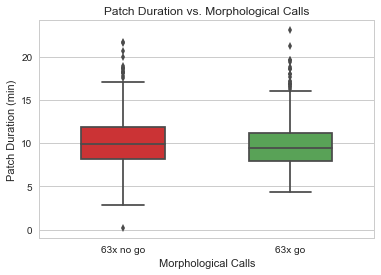

In [33]:
sns.boxplot(x = "Morphology", 
            y = "Patch Duration", 
            data = final_df[final_df['Patch Duration'] > 0.0],
            palette = ['#e41a1c', '#4daf4a'],
            width = 0.5).set_title("Patch Duration vs. Morphological Calls")
plt.xlabel("Morphological Calls")
plt.ylabel("Patch Duration (min)")
#plt.savefig("box_patch_duration_vs_morph")

##### Box Plot of Patch Duration vs Post Patch Outcomes

In [34]:
sns.boxplot(x = "post patch class", 
            y = "Patch Duration", 
            data = final_df[final_df['Patch Duration'] > 0.0],
            palette = ['#e41a1c', '#4daf4a'],
            width = 0.5).set_title("Patch Duration vs. Post Patch Outcomes")
plt.xlabel("Post Patch Outcomes")
plt.ylabel("Patch Duration (min)")
#plt.savefig("box_patch_duration_vs_morph")

ValueError: Could not interpret input 'post patch class'

##### Box Plot of Patch Duration vs Morphological Calls per Post Post Outcomes

In [ ]:
sns.boxplot(x = "post patch class", 
            y = "Patch Duration", 
            hue = "Morphology", 
            data = final_df, 
            palette = ["#e41a1c", "#4daf4a"]).set_title("Patch Duration vs. Morphological Calls per Post Patch Outcomes")
plt.xlabel("Post Patch Outcomes")
plt.ylabel("Patch Duration (min)")
#plt.legend(loc = "upper right")
#plt.savefig("box_patch_duration_vs_morph_user")